To make a meaningful comparison I think I need to know more about my source behaviour. However I can still get a point spread function!

In [1]:
from ParticleTracerClass import ParticleTracer
from phaseSpaceAnalyzer import SwarmSnapShot
import dill
from tqdm import tqdm
import time
from SwarmTracerClass import SwarmTracer
import warnings
import numpy as np
from ParticleClass import Swarm,Particle
from ParticleClass import Particle as ParticleBase
from ParticleTracerLatticeClass import ParticleTracerLattice
import matplotlib.pyplot as plt
import pathos as pa
import random


LObject=75.0E-2
LImage=85E-2
LLensHardEdge=15.24e-2
rpLens=(5e-2,5e-2 +2.54e-2)
magnetWidth=(.0254,.0254*1.5)

fringeFrac=1.5
LFringe=fringeFrac*max(rpLens)
LLens=LLensHardEdge+2*LFringe
LObject-=LFringe
LImage-=LFringe

PTL=ParticleTracerLattice(v0Nominal=210.0,latticeType='injector',parallel=True)
PTL.add_Drift(LObject,ap=.07)
PTL.add_Halbach_Lens_Sim(rpLens,LLens,apFrac=1.0,magnetWidth=magnetWidth)
PTL.add_Drift(LImage*2,ap=.07)
assert PTL.elList[1].fringeFracOuter==fringeFrac and abs(PTL.elList[1].Lm-LLensHardEdge)<1e-9
PTL.end_Lattice()

xSigMin=abs(PTL.elList[-1].r1[0])
xSigMax=abs(PTL.elList[-1].r2[0])


# Helper functions

In [2]:

class Interpolater:
    def __init__(self,swarm,PTL):
        self.swarm=swarm
        self.PTL=PTL
        self.endDriftLength=abs(self.PTL.elList[-1].r2[0]-self.PTL.elList[-1].r1[0])
    def __call__(self,xOrbit,maxRadius=np.inf,vTMax=np.inf):
        #xOrbit: Distance in orbit frame, POSITIVE to ease with analyze. Know that the tracing is done with x being negative
        #returns in units of mm
        #vTMax: maximum transverse velocity for interpolation
        assert -self.PTL.elList[-1].r2[0]>xOrbit>-self.PTL.elList[-1].r1[0]
        qList=[]
        pList=[]
        for particle in self.swarm:
            vT=np.sqrt(particle.pf[1]**2+particle.pf[2]**2)
            if particle.qf[0]<-xOrbit and vT<vTMax:
                stepFrac=(abs(particle.qf[0])-xOrbit)/self.endDriftLength
                ySlope=particle.pf[1]/particle.pf[0]
                y=particle.qf[1]+stepFrac*self.endDriftLength*ySlope
                zSlope=particle.pf[2]/particle.pf[0]
                z=particle.qf[2]+stepFrac*self.endDriftLength*zSlope
                if np.sqrt(z**2+y**2)<maxRadius:
                    qList.append([xOrbit,y,z])
                    pList.append(particle.pf)
        qArr=np.asarray(qList)
        pArr=np.asarray(pList)
        return qArr,pArr

# Load simulated particles, with final position and velocity, assuming they havne't been clipped for skimmer survival

In [3]:
#load and flip longitudinal velocity
import pandas as pd
data = np.asarray(pd.read_csv('particles.txt', delim_whitespace=True, header=None))
np.random.shuffle(data) #only shuffles along first axis
assert data.shape[1]==6
print('number of particles:', len(data))
data[:,0]*=-1
data[:,3]*=-1
vHeTerminal=210

number of particles: 10000000


In [4]:
#only add particles that pass through the skimmer
import multiprocess as mp
import numba
xSkimmer=-16e-2
DSkimmer=2.54E-2
simEndX=-.05
onlyThermalized=True
vCutoff=10.0
@numba.njit()
def is_Initial_Pos_Valid(qi):
    #some particles can make it through the skimmer, but startred in some weird spot
    eps=1e-3
    if qi[0]-simEndX>eps:
        return False
    else: return True
@numba.njit()
def is_Particle_Valid(qi,pi):
    dt=(xSkimmer-qi[0])/pi[0]
    qAtSkimmer=qi+pi*dt
    r=np.linalg.norm(qAtSkimmer[1:]) #get radius using y and z
    if (abs(pi[0])-vHeTerminal)>vCutoff and onlyThermalized==True:
        return False
    if r<DSkimmer/2 and is_Initial_Pos_Valid(qi):
        if dt<0.0:print(qi,pi)
        return True
    else:
        return False


swarmInitial=Swarm()
for Xi in data:
    qi=Xi[:3]
    pi=Xi[3:]
    if is_Particle_Valid(qi,pi)==True:
        swarmInitial.add_Particle(qi=qi,pi=pi)
print(swarmInitial.num_Particles())

41373


# Trace Swarm and make interp funcion

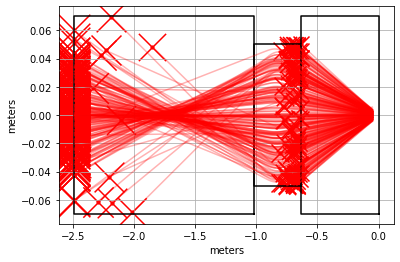

In [5]:
#visually inspect the result of tracing with a small number of particles
%matplotlib inline
swarmTracer=SwarmTracer(PTL)
swarmSmall=Swarm()
swarmSmall.particles=swarmInitial.particles[:300]
h=1e-5 #time step, s
T=1.0 #s, sufficient for linear tracing through lens
fastMode=False

swarmTraced=swarmTracer.trace_Swarm_Through_Lattice(swarmSmall,h,1.0,fastMode=fastMode,copySwarm=True,parallel=True,stepsBetweenLogging=4)
PTL.show_Lattice(swarm=swarmTraced,showTraceLines=True,trueAspectRatio=False,traceLineAlpha=.3)

In [7]:
#trace swarm and interpolate
swarmTracer=SwarmTracer(PTL)
h=5e-6 #time step, s
T=1.0 #s, sufficient for linear tracing through lens
fastMode=True
t=time.time()
swarmTraced=swarmTracer.trace_Swarm_Through_Lattice(swarmInitial,h,1.0,fastMode=fastMode,copySwarm=True,parallel=True)

#only save the ones that surved past the magnet end

survivedParticles=[]
for particle in swarmTraced.particles:
    if particle.qf[0]<-xSigMin:
        survivedParticles.append(particle)
swarmTraced.particles=survivedParticles

print('time to run,s :',time.time()-t) #23

print('num particles: ',swarmTraced.num_Particles())
interpFunction=Interpolater(swarmTraced,PTL)
# PTL.show_Lattice(swarm=swarmTraced,showTraceLines=True,trueAspectRatio=False)

time to run,s : 28.038992881774902
num particles:  26392


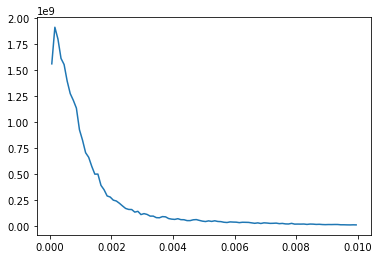

In [8]:
def get_Floursence_Signal(x,binNum=100,maxRadius=np.inf,vTMax=np.inf):
    #given an x, return the signal that we would collect with a laser. Sensitive to binNum
    qArr,pArr=interpFunction(x,maxRadius=maxRadius,vTMax=vTMax)
    yArr=qArr[:,1]
    zArr=qArr[:,2]
    rArr=np.sqrt(yArr**2+zArr**2)
    signal,bins=np.histogram(rArr,bins=binNum)
    binSize=bins[1]-bins[0]
    rBinArr=bins[:-1]+binSize/2
    radiusWeight=1/(rBinArr*binSize*2*np.pi)
    signal=signal*radiusWeight
    return rBinArr,signal
plt.plot(*get_Floursence_Signal(1.8,maxRadius=.01))
plt.show()

# Absorption image function

0.5639587753864808


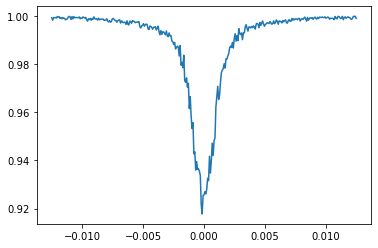

In [27]:
lam=671e-9
F0=1e12
yIndex=2 #horizontal ax, in and out of image
zIndex=1 #vertical ax, up down in image
xIndex=0 #longitudinal axis
numParticles=swarmTraced.num_Particles()
def cross_Section(deltaF,gamma=5.9):
    #deltaF: frequency in MHz
    #gamma: fwhm in MHz
    alignmentFactor=3
    A21=3.689E7 #einstein coefficient
    lam=671e-9
    sigma0=alignmentFactor*A21*lam**2/4.0
    L=((gamma*1e6/2)/((deltaF*1e6)**2+(gamma*1e6/2)**2))/np.pi
    return sigma0*L/6.28 #unit
def scattering(pArr,pixelSize):
    freqArr=speed_To_Freq_Shift(pArr[:,yIndex])
    sigmaArr=cross_Section(freqArr)
    assert np.all(pArr[:,xIndex]<0) #propogating to the left
    #below comes from theory motivated by considering particles in an imaginary box.
    numEffectiveParticlesArr=pixelSize*F0/(np.abs(pArr[:,xIndex])*numParticles)
    fracCross=sigmaArr/pixelSize**2 #ratio of cross section to pixel area
    responseArr=(1-fracCross)**numEffectiveParticlesArr
    return responseArr
def speed_To_Freq_Shift(s):
    #s: speed in m/s
    return (s/lam)/1e6  #in units of MHz
def get_Transmission_In_Pixel(qArr,pArr,pixelZCoord,pixelSize):
    #some obnoxoius collisions of coordinate system naming
    assert pixelSize>0.0
    pixelZBounds=[pixelZCoord-pixelSize/2,pixelZCoord+pixelSize/2]
    zArr=qArr[:,zIndex]
    pArr=pArr[(zArr<pixelZBounds[1]) & (zArr>pixelZBounds[0])]
    scatterFracArr=scattering(pArr,pixelSize) #each entry comes simulated atoms with proper weight
    assert np.all((scatterFracArr>=0.0) & (scatterFracArr<=1.0))
    I=1.0
    for scatteringFraction in scatterFracArr:
        I=I*scatteringFraction
    return I
def get_Column_Image(xColumn,pixelSize=.075e-3,approxHeight=.045):
    pixels=int(approxHeight/pixelSize)
    height=pixels*pixelSize #actual height based on number of pixels
    assert pixels>2
    qArr,pArr=interpFunction(xColumn) #phase space coords
    temp=qArr[:,1:]
    temp=temp[np.linalg.norm(temp,axis=1)<.01]
    theta=np.pi
    R=np.asarray([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    for row in qArr:
        row[1:]=R@row[1:]

    pixelZCoords=np.linspace(0.0,1.0,pixels)*height-height/2.0
    absorptionList=[]
    for pixelZCoord in pixelZCoords:
        absorptionList.append(get_Transmission_In_Pixel(qArr,pArr,pixelZCoord,pixelSize))
    return pixelZCoords,np.asarray(absorptionList)
def get_Fractional_Flux_In_Circle(x,radius):
    qArr,pArr=interpFunction(x)

    num=np.sum(np.linalg.norm(qArr[:,1:],axis=1)<radius)
    return num/numParticles

xArr=[1.8]
for x in xArr:
    print(get_Fractional_Flux_In_Circle(1.8,.005)*F0/1e12)
    yPos,signal=get_Column_Image(x,approxHeight=2.5e-2)
    plt.plot(yPos,signal)
    plt.show()

In [28]:
cross_Section(0),3*671e-9**2/6.28

(2.1403432458925438e-13, 2.1508328025477707e-13)